In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

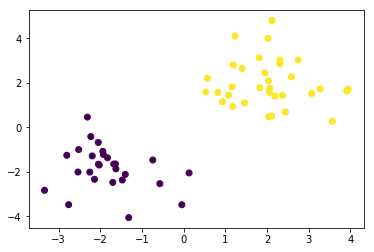

In [2]:
data, target = make_blobs(centers=([-2,-2],[2,2]), n_features=2, n_samples=100, random_state=87)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.4, random_state = 78)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)
plt.show()

In [3]:
# def softplus(X):
#     X = np.array(X)
#     return np.log(1+np.exp(X))

# define the activation funcion used in the model
def sigmoid(z):
    z = np.array(z)
    return 1/(1+np.exp(-z))
# define the loss function
def loss_(y_train, a3):
    y_train, a3 = y_train.ravel(), a3.ravel()
    return -np.sum(y_train*np.log(a3)+(1-y_train)*np.log(1-a3))/len(y_train)
# to make a true input when doing FP
def input_(X):
    m,n = np.size(X,0), np.size(X,1)
    ones = np.ones((m,1))
    return np.concatenate((X,ones), axis = 1)
# just return the sizes of a given array
def size_val(X):
    return np.size(X,0), np.size(X,1)
# to generate a list of weight matrice at the begining
def w_(layers, ϵ):
    l1, l2 = layers[:-1], layers[1:]
    shapes = np.c_[l1+1,l2]
    w_lys = [(2*ϵ*np.random.random((s[0],s[1]))-ϵ) for s in shapes]
    return w_lys
# to calculate the gradient by required out, real out and real input C at a layer
def Δw(out, out_r, C):
    δw = np.linalg.pinv(np.matrix(C))*np.matrix(out-out_r)
    return np.array(δw)
# to calculate the required input of the previous layer
def req_in(out_r, w):
    m, n = size_val(out_r)
    w_arr, b_arr = w[:-1,:], np.tile(w[-1,:], reps = (m,1))
    req = np.matrix(out_r-b_arr)*np.linalg.pinv(w_arr)
    return np.array(req)
# to predict a test set
def predict(X_test, w):
    C1, w1 = input_(X_test), w[0] 
    a1 = sigmoid(np.matrix(C1)*np.matrix(w1))
    C2, w2 = input_(a1), w[1]
    a2 = sigmoid(np.matrix(C2)*np.matrix(w2))
    C3, w3 = input_(a2), w[2]
    a3 = sigmoid(np.matrix(C3)*np.matrix(w3))
    a3[a3 > 0.5] = 1
    a3[a3 <= 0.5] = 0
    return a3.astype("int")
# define a function to read the initial weights
def read_w(path, name_list):
    return [pd.read_excel(path, sheet_name= name).values for name in name_list]

In [4]:
m, n = size_val(X_train) 
layers = np.array([n,2,3,1])
epochs = 20000
ϵ = 3
α = 3e-4

#w =w_(layers, ϵ)
name_list = ["w1", "w2", "w3"]
w = read_w("./weights.xlsx", name_list)

J = [0]

for i in range(epochs):
    # FP algorithm
    C1, w1 = input_(X_train), w[0] # input and its weight
    a1 = sigmoid(np.matrix(C1)*np.matrix(w1)) # output
    C2, w2 = input_(a1), w[1]
    a2 = sigmoid(np.matrix(C2)*np.matrix(w2))
    C3, w3 = input_(a2), w[2]
    a3 = sigmoid(np.matrix(C3)*np.matrix(w3))
    # BP algoritm by use of pseudo inverse method instead of Gradient Decent
    # the adjustment will be done lalyer by layer
    # at last layer:
    a3_r = y_train.reshape(-1,1)
    w3 -= α*Δw(a3, a3_r, C3)
    # at second layer
    a2_r = req_in(a3_r, w3)
    w2 -= α*Δw(a2, a2_r, C2)
    # at first layer
    a1_r = req_in(a2_r,w2)
    w1 -= α*Δw(a1,a1_r, C1)
    # w updated and loss function calculation
    w = [w1,w2,w3]
    J += [loss_(y_train, a3)]
    if (abs(J[-1]-J[-2]) < 1e-5) & (J[-1] < J[-2]) & (J[-1] < 0.7):
        print("converged at {}ᵗʰ step".format(i))
        print("loss = {}".format(J[-1]))
        break;

converged at 12322ᵗʰ step
loss = 0.05123743338579329


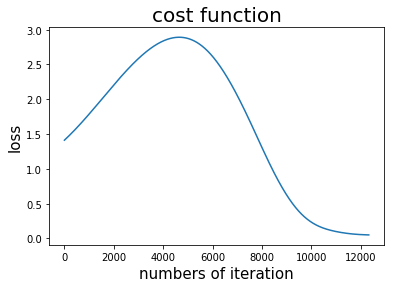

In [5]:
plt.plot(range(len(J[1:])), J[1:])
plt.title("cost function", fontsize = 20)
plt.xlabel("numbers of iteration", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.show()

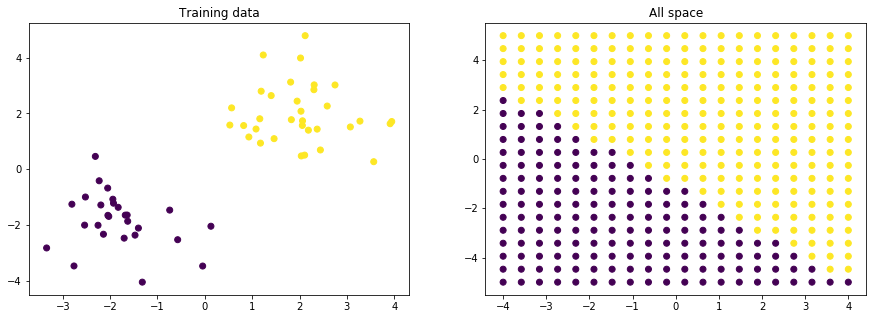

In [6]:
X_grid, Y_grid = np.meshgrid(np.linspace(-4,4,20), np.linspace(-5,5,20))
X_all = np.c_[X_grid.ravel(),Y_grid.ravel()]
y_all = predict(X_all, w).ravel()

plt.figure(figsize=(15,5))

for sub_plt, title, x, y in zip([121,122],["Training data","All space"],[X_train, X_all], [y_train, y_all]):
    plt.subplot(sub_plt)
    plt.title(title)
    plt.scatter(x[:,0], x[:,1], c = y)

plt.show()

In [7]:
# df_w1 = pd.DataFrame(w1, columns = ["1","2"])
# df_w2 = pd.DataFrame(w2, columns = ["1","2","3"])
# df_w3 = pd.DataFrame(w3, columns = ["1"])
# df_list = [df_w1,df_w2,df_w3]
# sheets = ["w1", "w2", "w3"]

# writer = pd.ExcelWriter("./weights.xlsx")

# for df , name in zip(df_list, sheets):
#     df.to_excel(writer, sheet_name = name)

# writer.save()
# writer.close()